# 테스트 하실때, 주석처리되지 않은 부분들을 실행하시면 segmentation_coordinates_updated.csv이 생성이 됩니다.
# 배울 수 있어서 정말 즐거웠습니다. 고생 많으셨습니다.
![title](Guide.png)

# Preparation

### 데이터 준비 후 yaml파일을 설정합니다.

In [ ]:
# !pip install PyYAML

In [ ]:
"""
# yaml 파일을 학습이 가능하도록 경로 설정.
# key-value 데이터인 dict 데이터타입으로 data['train'], data['val'], data['nc'], data['names'] 에 넣어주는데,
# 가장 중요한 부분은 데이터 경로 설정임.
import yaml

data = { 'train' : '/data/ai_users/cmpts11/competitionImage_noneBox/train/',
         'val' : '/data/ai_users/cmpts11/competitionImage_noneBox/val/',
         'test' : '/data/ai_users/cmpts11competitionImage_noneBox/test/',
         'names' : ['BumpHigh', 'BumpLow', 'BumpMiddle', 'CrosswalkHigh', 'CrosswalkLow', 'CrosswalkMiddle'],
         'nc' : 6 }

with open('/data/ai_users/cmpts11/competitionImage_noneBox/data.yaml', 'w') as f:
  yaml.dump(data, f)


with open('/data/ai_users/cmpts11/competitionImage_noneBox/data.yaml', 'r') as f:
 competitionImage_noneBox_yaml = yaml.safe_load(f)
 display(competitionImage_noneBox_yaml)
 """

In [ ]:
"""
# yaml 파일 확인
!cat /data/ai_users/cmpts11/competitionImage/data.yaml
"""

### 폴리곤 좌표값을 디텍션 값으로 추출

In [ ]:
"""
import os
import re

# 이미지 파일이 있는 디렉토리
label_dir = '/data/ai_users/cmpts11/competitionImage/crosswalk/CrosswalkMiddle/labels/'

# 라벨 파일을 저장할 디렉토리
segmentation_dir = '/data/ai_users/cmpts11/competitionImage/crosswalk/CrosswalkMiddle/labels/'

# 라벨 파일 목록
label_files = os.listdir(label_dir)

# 이미지의 너비와 높이
image_width = 1024
image_height = 1024

# 라벨 파일의 내용 읽어와서 변환 후 저장
for label_file in label_files:
    if label_file.endswith('.txt'):
        label_path = os.path.join(label_dir, label_file)
        segmentation_path = os.path.join(segmentation_dir, label_file)
        
        # 이미지 파일 이름에서 폴리곤 좌표 추출
        match = re.search(r'_(\([^)]+\))', label_file)
        if match:
            polygon_coords_str = match.group(1)
            coords_list = [int(coord) for coord in re.findall(r'\d+', polygon_coords_str)]
            
            # 폴리곤 좌표 변환
            yolo_coords = []
            for i in range(0, len(coords_list), 2):
                x = coords_list[i]
                y = coords_list[i + 1]
                
                yolo_x = x / image_width
                yolo_y = y / image_height
                
                yolo_coords.extend([yolo_x, yolo_y])
            
            # 변환된 YOLO 이미지 세그멘테이션 좌표값 저장
            yolo_segmentation_content = ' '.join([str(len(coords_list) // 2)] + [f'{coord:.10f}' for coord in yolo_coords])
            with open(segmentation_path, 'w') as f:
                f.write(yolo_segmentation_content)
            
            print(f"Created YOLO segmentation file: {segmentation_path}")
"""

### 폴리곤 좌표값을 세그멘테이션으로 추출

In [ ]:
"""
import os
import re

# 라벨 파일이 있는 디렉토리
label_dir = 'sampleImage/train'

# YOLO 이미지 세그멘테이션 좌표를 저장할 디렉토리
segmentation_dir = 'sampleImage/train'

# 라벨 파일 목록 가져오기
label_files = os.listdir(label_dir)

# 이미지의 너비와 높이
image_width = 1024
image_height = 1024

# 라벨 파일의 내용 읽어와서 변환 후 저장
for label_file in label_files:
    if label_file.endswith('.txt'):
        label_path = os.path.join(label_dir, label_file)
        
        with open(label_path, 'r') as f:
            label_content = f.read().strip()  # 기존 라벨링 내용을 읽어옴
        
        # 이미지 파일 이름에서 폴리곤 좌표 추출
        match = re.search(r'_(\([^)]+\))', label_file)
        if match:
            polygon_coords_str = match.group(1)
            coords_list = [int(coord) for coord in re.findall(r'\d+', polygon_coords_str)]
            
            # 기존 라벨링 첫 번째 숫자 추출
            original_label = int(label_content.split()[0])
            
            # 폴리곤 좌표 변환
            yolo_coords = []
            for i in range(0, len(coords_list), 2):
                x = coords_list[i]
                y = coords_list[i + 1]
                
                yolo_x = x / image_width
                yolo_y = y / image_height
                
                yolo_coords.extend([yolo_x, yolo_y])
            
            # 변환된 YOLO 이미지 세그멘테이션 좌표값을 덮어씌우기 (첫 번째 숫자는 그대로 유지)
            yolo_segmentation_content = ' '.join([str(original_label)] + [f'{coord:.10f}' for coord in yolo_coords])
            with open(label_path, 'w') as f:
                f.write(yolo_segmentation_content)
            
            print(f"Updated YOLO segmentation in file: {label_path}")
"""

![title](segmentations_coor.png)

### 잘 라벨링이 되었는지 확인합니다.

In [ ]:
"""
# define helper functions to show images - polygon shape
def imShow(path, lb_path):
  import cv2
  import matplotlib.pyplot as plt
  import numpy as np
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]

  file = open(lb_path, "r")
  strings = file.readlines()
  file.close()

  # Draw a rectangle with blue line borders of thickness of 2 px
  for line in strings:
    line = line.split()
    label = line[0]
    pts = []
    for index in range(1,len(line[1:])+1, 2):
      x_pt = int(width*float(line[index]))
      y_pt = int(height*float(line[index+1]))
      pts.append([x_pt,y_pt])

    pts = np.array(pts).reshape(1, -1, 2)

    image = cv2.polylines(image, pts, isClosed=True, color=(0, 255, 0), thickness=2)

  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()
  """

In [ ]:
# imShow('/data/ai_users/cmpts11/competitionImage/val/images/(B040)항공사진_202202205C00990027_24576_12288_(590,655-774,640-780,714-596,727).png','/data/ai_users/cmpts11/competitionImage/val/labels/(B040)항공사진_202202205C00990027_24576_12288_(590,655-774,640-780,714-596,727).txt')

### 추가로 이미지 사이즈를 확인합니다.

In [ ]:
"""
from PIL import Image

# 이미지 파일 경로
image_path = '/data/ai_users/cmpts11/competitionImage/train/images/(B040)항공사진_202202205C01150018_14336_1024_(936,424-999,392-984,363-930,389).png'

# 이미지 열기
image = Image.open(image_path)

# 이미지의 너비와 높이 가져오기
image_width = image.width
image_height = image.height

print("Image Width:", image_width)
print("Image Height:", image_height)
"""

### 이미지 노이즈

In [ ]:
#가우시안 블러
"""
import cv2
import os

# 입력 이미지 폴더 경로
input_folder = 'competitionImage_noneBox/images_noise/CrosswalkMiddle/images'

# 가우시안 블러 적용 후 이미지 저장할 폴더 경로
output_folder = 'competitionImage_noneBox/images_noise/CrosswalkMiddle/images'

# 가우시안 블러를 적용할 커널 크기
kernel_size = (3, 3)

# 입력 이미지 폴더 내의 모든 이미지 파일에 대해 가우시안 블러 적용
for filename in os.listdir(input_folder):
    if filename.endswith('.png'):
        input_image_path = os.path.join(input_folder, filename)
        image = cv2.imread(input_image_path)
        blurred_image = cv2.GaussianBlur(image, kernel_size, 0)
        
        output_filename = filename.replace('.png', 'gaussian_noise.png')
        output_image_path = os.path.join(output_folder, output_filename)
        cv2.imwrite(output_image_path, blurred_image)

print("가우시안 블러 적용 및 저장 완료")
"""
#솔트 앤 페퍼
"""
import cv2
import os
import numpy as np

# 입력 이미지 폴더 경로
input_folder = 'competitionImage_noneBox/images_noise/CrosswalkMiddle/images'

# 노이즈를 적용한 이미지 저장할 폴더 경로
output_folder = 'competitionImage_noneBox/images_noise/CrosswalkMiddle/images'

# 노이즈를 적용할 확률 (예: 0.1은 10% 확률로 노이즈를 적용)
noise_probability = 0.005

# 입력 이미지 폴더 내의 모든 이미지 파일에 대해 노이즈 적용
for filename in os.listdir(input_folder):
    if filename.endswith('.png'):
        input_image_path = os.path.join(input_folder, filename)
        image = cv2.imread(input_image_path)
        
        # 이미지의 형태와 같은 크기의 랜덤한 값 생성
        salt_pepper = np.random.rand(*image.shape[:2])
        salt = salt_pepper < noise_probability / 2
        pepper = salt_pepper > 1 - noise_probability / 2
        
        # 솔트 앤 페퍼 노이즈 추가
        image[salt] = [255, 255, 255]  # 흰색 (솔트)
        image[pepper] = [0, 0, 0]      # 검정색 (페퍼)
        
        output_filename = filename.replace('.png', '_salt_pepper.png')
        output_image_path = os.path.join(output_folder, output_filename)
        cv2.imwrite(output_image_path, image)

print("솔트 앤 페퍼 노이즈 적용 및 저장 완료")
"""
#좌우반전
"""
import cv2
import os

# 입력 이미지 폴더 경로
input_folder = 'competitionImage_noneBox/images_noise/CrosswalkMiddle/images'
# 좌우 반전된 이미지를 저장할 폴더 경로
output_folder = 'competitionImage_noneBox/images_noise/CrosswalkMiddle/images'

# 입력 이미지 폴더 내의 모든 이미지 파일에 대해 좌우 반전 적용
for filename in os.listdir(input_folder):
    if filename.endswith('.png'):
        input_image_path = os.path.join(input_folder, filename)
        image = cv2.imread(input_image_path)
        
        # 이미지 좌우 반전
        flipped_image = cv2.flip(image, 1)  # 1은 좌우 반전을 의미
        
        output_filename = filename.replace('.png', '_flipped.png')
        output_image_path = os.path.join(output_folder, output_filename)
        cv2.imwrite(output_image_path, flipped_image)

print("이미지 좌우 반전 및 저장 완료")
"""
#상하반전
"""
import cv2
import os

# 입력 이미지 폴더 경로
input_folder = 'competitionImage_noneBox/images_noise/CrosswalkMiddle/images'
# 상하 반전된 이미지를 저장할 폴더 경로
output_folder = 'competitionImage_noneBox/images_noise/CrosswalkMiddle/images'

# 입력 이미지 폴더 내의 모든 이미지 파일에 대해 상하 반전 적용
for filename in os.listdir(input_folder):
    if filename.endswith('.png'):
        input_image_path = os.path.join(input_folder, filename)
        image = cv2.imread(input_image_path)
        
        # 이미지 상하 반전
        flipped_image = cv2.flip(image, 0)  # 0은 상하 반전을 의미
        
        output_filename = filename.replace('.png', '_flipped_vertical.png')
        output_image_path = os.path.join(output_folder, output_filename)
        cv2.imwrite(output_image_path, flipped_image)

print("이미지 상하 반전 및 저장 완료")
"""

![title](salt.png)

# 반전된 이미지의 좌표를 맞게 수정하는 코드

In [ ]:
#좌우반전
"""
import os
import re

# 라벨 파일이 있는 디렉토리
label_dir = 'competitionImage_noneBox/bump/BumpMiddle'

# YOLO 이미지 세그멘테이션 좌표를 저장할 디렉토리
segmentation_dir = 'competitionImage_noneBox/images_noise/CrosswalkMiddle/labels'

# 라벨 파일 목록 가져오기
label_files = os.listdir(label_dir)

# 이미지의 너비와 높이
image_width = 1024
image_height = 1024

# 라벨 파일의 내용 읽어와서 변환 후 저장
for label_file in label_files:
    if label_file.endswith('.txt'):
        label_path = os.path.join(label_dir, label_file)
        
        with open(label_path, 'r') as f:
            label_content = f.read().strip()  # 기존 라벨링 내용을 읽어옴
        
        # 이미지 파일 이름에서 폴리곤 좌표 추출
        match = re.search(r'_(\([^)]+\))', label_file)
        if match:
            polygon_coords_str = match.group(1)
            coords_list = [int(coord) for coord in re.findall(r'\d+', polygon_coords_str)]
            
            # 기존 라벨링 첫 번째 숫자 추출
            original_label = int(label_content.split()[0])
            
            # 폴리곤 좌표 변환
            yolo_coords = []
            for i in range(0, len(coords_list), 2):
                x = coords_list[i]
                y = coords_list[i + 1]
                
                yolo_x = x / image_width
                yolo_y = y / image_height
                
                yolo_coords.extend([yolo_x, yolo_y])
            
            # 변환된 YOLO 이미지 세그멘테이션 좌표값을 덮어씌우기 (첫 번째 숫자는 그대로 유지)
            yolo_segmentation_content = ' '.join([str(original_label)] + [f'{coord:.10f}' for coord in yolo_coords])
            
            # YOLO 세그멘테이션 값을 좌우 반전시키기
            yolo_segmentation_values = yolo_segmentation_content.split()
            flipped_yolo_segmentation_values = [yolo_segmentation_values[0]]  # 첫 번째 숫자 그대로 유지
            for i in range(1, len(yolo_segmentation_values), 2):
                yolo_x = float(yolo_segmentation_values[i])
                flipped_x = 1.0 - yolo_x  # 좌우 반전
                
                flipped_yolo_segmentation_values.extend([f'{flipped_x:.10f}', yolo_segmentation_values[i + 1]])
            
            flipped_yolo_segmentation_content = ' '.join(flipped_yolo_segmentation_values)
            
            # 좌우 반전된 YOLO 세그멘테이션 값을 라벨 파일에 저장
            segmentation_output_path = os.path.join(segmentation_dir, label_file)
            with open(segmentation_output_path, 'w') as f:
                f.write(flipped_yolo_segmentation_content)
            
            print(f"Updated and flipped YOLO segmentation in file: {segmentation_output_path}")
"""
#상하반전
"""
import os
import re

# 라벨 파일이 있는 디렉토리
label_dir = 'competitionImage_noneBox/images_noise/CrosswalkMiddle/labels'

# YOLO 이미지 세그멘테이션 좌표를 저장할 디렉토리
segmentation_dir = 'competitionImage_noneBox/images_noise/CrosswalkMiddle/labels'

# 라벨 파일 목록 가져오기
label_files = os.listdir(label_dir)

# 이미지의 너비와 높이
image_width = 1024
image_height = 1024

# 라벨 파일의 내용 읽어와서 변환 후 저장
for label_file in label_files:
    if label_file.endswith('.txt'):
        label_path = os.path.join(label_dir, label_file)
        
        with open(label_path, 'r') as f:
            label_content = f.read().strip()  # 기존 라벨링 내용을 읽어옴
        
        # 이미지 파일 이름에서 폴리곤 좌표 추출
        match = re.search(r'_(\([^)]+\))', label_file)
        if match:
            polygon_coords_str = match.group(1)
            coords_list = [int(coord) for coord in re.findall(r'\d+', polygon_coords_str)]
            
            # 기존 라벨링 첫 번째 숫자 추출
            original_label = int(label_content.split()[0])
            
            # 폴리곤 좌표 변환
            yolo_coords = []
            for i in range(0, len(coords_list), 2):
                x = coords_list[i]
                y = coords_list[i + 1]
                
                yolo_x = x / image_width
                yolo_y = y / image_height
                
                yolo_coords.extend([yolo_x, yolo_y])
            
            # 변환된 YOLO 이미지 세그멘테이션 좌표값을 덮어씌우기 (첫 번째 숫자는 그대로 유지)
            yolo_segmentation_content = ' '.join([str(original_label)] + [f'{coord:.10f}' for coord in yolo_coords])
            
            # YOLO 세그멘테이션 값을 상하로 반전시키기
            yolo_segmentation_values = yolo_segmentation_content.split()
            flipped_yolo_segmentation_values = [yolo_segmentation_values[0]]  # 첫 번째 숫자 그대로 유지
            for i in range(1, len(yolo_segmentation_values), 2):
                yolo_y = float(yolo_segmentation_values[i + 1])
                flipped_y = 1.0 - yolo_y  # 상하 반전
                
                flipped_yolo_segmentation_values.extend([yolo_segmentation_values[i], f'{flipped_y:.10f}'])
            
            flipped_yolo_segmentation_content = ' '.join(flipped_yolo_segmentation_values)
            
            # 상하 반전된 YOLO 세그멘테이션 값을 라벨 파일에 저장
            segmentation_output_path = os.path.join(segmentation_dir, label_file)
            with open(segmentation_output_path, 'w') as f:
                f.write(flipped_yolo_segmentation_content)
            
            print(f"Updated and flipped YOLO segmentation in file: {segmentation_output_path}")
"""

### 라이브러리 준비

In [ ]:
#!pip install ultralytics

In [87]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.28 🚀 Python-3.10.9 torch-2.0.1+cu117 CPU
Setup complete ✅ (32 CPUs, 121.8 GB RAM, 16.0/16.6 GB disk)


# train

In [ ]:
### !yolo task=segment mode=train model=yolov8n-seg.pt imgsz=1024 data=/data/ai_users/cmpts11/competitionImage_noneBox/data.yaml epochs=100 batch=16 name=yolov8n-seg exist_ok=True

# test

In [88]:
#test할 사진들이 있는 폴더의 좌표를 수정해야 합니다.
!yolo task=segment mode=predict model=competitionImage/runs/segment/yolov8n-seg/weights/best.pt conf=0.3 source=/data/ai_users/cmpts11/competitionImage_noneBox/test/images name=yolov8n_seg_infer_ftest exist_ok=True save_txt=True

Ultralytics YOLOv8.0.28 🚀 Python-3.10.9 torch-2.0.1+cu117 CPU
YOLOv8n-seg summary (fused): 195 layers, 3259234 parameters, 0 gradients, 12.0 GFLOPs

image 1/120 /data/ai_users/cmpts11/competitionImage_noneBox/test/images/(B040)항공사진_202202205C00920021_0_12288_(660,778-776,776-780,826-663,830).png: 640x640 1 CrosswalkLow, 1958.4ms
image 2/120 /data/ai_users/cmpts11/competitionImage_noneBox/test/images/(B040)항공사진_202202205C00920021_0_13312_(308,723-335,728-331,765-305,759).png: 640x640 1804.7ms
image 3/120 /data/ai_users/cmpts11/competitionImage_noneBox/test/images/(B040)항공사진_202202205C00920021_0_2048_(989,462-1021,474-1006,529-975,519).png: 640x640 1666.7ms
image 4/120 /data/ai_users/cmpts11/competitionImage_noneBox/test/images/(B040)항공사진_202202205C00920021_0_4096_(273,948-307,966-323,912-293,903).png: 640x640 1 BumpLow, 374.7ms
image 5/120 /data/ai_users/cmpts11/competitionImage_noneBox/test/images/(B040)항공사진_202202205C00920021_10240_1024_(936,565-994,527-1016,556-954,599).png: 640x640 

### 무수히 나온 좌표를 왼쪽 아래 꼭지점, 오른쪽 아래 꼭지점 오른쪽 위 꼭지점 왼쪽 위 꼭지점을 통해 8개의 좌표로 간소화 테스트

![title](many.png)

In [69]:
"""
def convert_to_8_coordinates(coords):
    coords = list(map(float, coords))
    x_coords = coords[1::2]
    y_coords = coords[2::2]
    
    x_sorted = sorted(x_coords)
    y_sorted = sorted(y_coords)
    
    x_min = x_sorted[0]
    x_max = x_sorted[-1]
    y_min = y_sorted[0]
    y_max = y_sorted[-1]
    
    x1, y1 = x_min, y_min
    x2, y2 = x_max, y_min
    x4, y4 = x_min, y_max
    x3, y3 = x_max, y_max
    
    return [
        f"{x1:.6f} {y1:.6f}",
        f"{x2:.6f} {y2:.6f}",
        f"{x3:.6f} {y3:.6f}",
        f"{x4:.6f} {y4:.6f}"
    ]

input_coords = "0 0.48125 0.38125 0.479688 0.382812 0.476562 0.382812 0.476562 0.384375 0.475 0.385938 0.475 0.389062 0.473437 0.390625 0.473437 0.392188 0.470313 0.395312 0.470313 0.396875 0.46875 0.398438 0.46875 0.4 0.467187 0.401563 0.467187 0.403125 0.464063 0.40625 0.464063 0.407813 0.4625 0.409375 0.4625 0.415625 0.464063 0.417188 0.464063 0.41875 0.467187 0.421875 0.46875 0.421875 0.470313 0.423438 0.473437 0.423438 0.475 0.425 0.478125 0.425 0.479688 0.426562 0.48125 0.426562 0.482812 0.428125 0.484375 0.428125 0.485938 0.429688 0.49375 0.429688 0.495313 0.43125 0.498437 0.428125 0.498437 0.423438 0.5 0.421875 0.5 0.420312 0.501562 0.41875 0.501562 0.417188 0.503125 0.415625 0.503125 0.414062 0.504687 0.4125 0.504687 0.409375 0.50625 0.407813 0.50625 0.40625 0.507812 0.404687 0.507812 0.403125 0.509375 0.401563 0.509375 0.4 0.510938 0.398438 0.510938 0.389062 0.509375 0.3875 0.509375 0.385938 0.507812 0.384375 0.50625 0.384375 0.504687 0.382812 0.5 0.382812 0.498437 0.38125"
coords = input_coords.split()

eight_coords = convert_to_8_coordinates(coords)

output_str = " ".join(eight_coords)
print(output_str)

"""

0.462500 0.381250 0.510938 0.381250 0.510938 0.431250 0.462500 0.431250


# csv파일 저장

In [90]:
# 혹시 몰라서 text파일로 저장
"""
import os
# 경로 지정을 test한 폴더안에있는 라벨폴더로 지정해야합니다.
input_directory = "runs/segment/yolov8n_seg_infer_ftest/labels"  # Replace with the path to the folder containing label files
output_txt_path = "segmentation_coordinates.txt"

class_mapping = {
    "0": ("Bump", "BumpHigh"),
    "1": ("Bump", "BumpLow"),
    "2": ("Bump", "BumpMiddle"),
    "3": ("Crosswalk", "CrosswalkHigh"),
    "4": ("Crosswalk", "CrosswalkLow"),
    "5": ("Crosswalk", "CrosswalkMiddle")
}

def convert_to_bbox_coordinates(coords):
    coords = list(map(float, coords))
    x_coords = coords[1::2]
    y_coords = coords[2::2]
    xmin = min(x_coords)
    xmax = max(x_coords)
    ymin = min(y_coords)
    ymax = max(y_coords)
    return [xmin, ymin, xmax, ymin, xmax, ymax, xmin, ymax]

def scale_bbox_to_image(bbox, image_width, image_height):
    scaled_bbox = [coord * image_width if idx % 2 == 0 else coord * image_height for idx, coord in enumerate(bbox)]
    return scaled_bbox

with open(output_txt_path, "w") as output_file:
    for filename in os.listdir(input_directory):
        if filename.endswith(".txt"):
            input_file_path = os.path.join(input_directory, filename)

            with open(input_file_path, "r") as input_file:
                lines = input_file.read().splitlines()

            for line in lines:
                parts = line.split()
                class_index = parts[0]
                category, label = class_mapping.get(class_index, ("UnknownCategory", "UnknownLabel"))
                coordinates = convert_to_bbox_coordinates(parts[1:])

                image_filename = filename.replace(".txt", ".png")  # Change extension if needed
                image_path = os.path.join(input_directory.replace("labels", "images"), image_filename)

                scaled_coordinates = scale_bbox_to_image(coordinates, image_width=1024, image_height=1024)
                
                output_line = f"cmpts11,{category},{label},{','.join(map(str, scaled_coordinates))},{image_path}\n"
                output_file.write(output_line)

print(f"텍스트 파일이 {output_txt_path}에 저장되었습니다.")
"""

텍스트 파일이 segmentation_coordinates.txt에 저장되었습니다.


### 세그멘테이션 좌표값에 맞게 저장

In [95]:
import os
#테스트이미지가 있는 폴더에 labels폴더가 생성됩니다. 따라서, labels폴더로 경로를 지정해야 합니다.
input_directory = "runs/segment/yolov8n_seg_infer_ftest/labels"  # Replace with the path to the folder containing label files
output_csv_path = "segmentation_coordinates.csv"  # Change extension to .csv

class_mapping = {
    "0": ("Bump", "BumpHigh"),
    "1": ("Bump", "BumpLow"),
    "2": ("Bump", "BumpMiddle"),
    "3": ("Crosswalk", "CrosswalkHigh"),
    "4": ("Crosswalk", "CrosswalkLow"),
    "5": ("Crosswalk", "CrosswalkMiddle")
}

def convert_to_4_coordinates(coords):
    coords = list(map(float, coords))
    x_coords = coords[1::2]
    y_coords = coords[2::2]
    
    x1, y1 = min(x_coords), min(y_coords)
    x2, y2 = max(x_coords), min(y_coords)
    x3, y3 = max(x_coords), max(y_coords)
    x4, y4 = min(x_coords), max(y_coords)
    
    return [
        f"{x1:.6f},{y1:.6f}",
        f"{x2:.6f},{y2:.6f}",
        f"{x3:.6f},{y3:.6f}",
        f"{x4:.6f},{y4:.6f}"
    ]

with open(output_csv_path, "w") as output_file:
    output_file.write("USRID,CATEGORY,LABEL,X1,Y1,X2,Y2,X3,Y3,X4,Y4,IMAGE_PATH\n")
    
    for filename in os.listdir(input_directory):
        if filename.endswith(".txt"):
            input_file_path = os.path.join(input_directory, filename)

            with open(input_file_path, "r") as input_file:
                lines = input_file.read().splitlines()

            for line in lines:
                parts = line.split()
                class_index = parts[0]
                category, label = class_mapping.get(class_index, ("UnknownCategory", "UnknownLabel"))
                coordinates = convert_to_4_coordinates(parts)

                image_filename = filename.replace(".txt", ".png")  # Change extension if needed
                image_path = os.path.join(input_directory.replace("labels", "images"), image_filename)

                output_line = f"cmpts11,{category},{label},{','.join(map(str, coordinates))},{image_path}\n"
                output_file.write(output_line)

print(f"CSV 파일이 {output_csv_path}에 저장되었습니다.")

CSV 파일이 segmentation_coordinates.csv에 저장되었습니다.


### 1024x1024의 좌표값으로 변환 테스트

In [86]:
"""
def convert_relative_to_absolute(coords, image_width, image_height):
    absolute_coords = [
        int(coord * image_width) if idx % 2 == 0 else int(coord * image_height)
        for idx, coord in enumerate(coords)
    ]
    return absolute_coords

# 주어진 상대적인 좌표값
relative_coords = [0.462500, 0.381250, 0.510938, 0.381250, 0.510938, 0.431250, 0.462500, 0.431250]

# 1024x1024 이미지 크기
image_width = 1024
image_height = 1024

# 상대적인 좌표값을 실제 이미지 좌표로 변환
absolute_coords = convert_relative_to_absolute(relative_coords, image_width, image_height)

print("변환된 절대 좌표값:", absolute_coords)
"""

변환된 절대 좌표값: [473, 390, 523, 390, 523, 441, 473, 441]


### 1024X1024 사이즈에 맞게 좌표값 저장

In [96]:
import csv

# 상대적인 좌표값을 절대 좌표값으로 변환하는 함수
def convert_relative_to_absolute(coords, image_width, image_height):
    absolute_coords = [
        int(coord * image_width) if idx % 2 == 0 else int(coord * image_height)
        for idx, coord in enumerate(coords)
    ]
    return absolute_coords

# 입력 CSV 파일 경로
input_csv_file_path = "segmentation_coordinates.csv"

# 출력 CSV 파일 경로
output_csv_file_path = "segmentation_coordinates_updated.csv"

# 1024x1024 이미지 크기
image_width = 1024
image_height = 1024

# 입력 CSV 파일 열기
with open(input_csv_file_path, "r") as input_csv_file:
    csv_reader = csv.reader(input_csv_file)
    header = next(csv_reader)  # 헤더 줄 읽기

    # 출력 CSV 파일 열기
    with open(output_csv_file_path, "w", newline="") as output_csv_file:
        csv_writer = csv.writer(output_csv_file)
        csv_writer.writerow(header)  # 헤더 줄 쓰기

        for row in csv_reader:
            category, label = row[1], row[2]
            absolute_coords = [float(coord) for coord in row[3:11]]  # x1, y1, x2, y2, x3, y3, x4, y4

            # 상대적인 좌표값을 실제 이미지 좌표로 변환
            image_coords = convert_relative_to_absolute(absolute_coords, image_width, image_height)

            # 새로운 행 쓰기
            new_row = [row[0], category, label] + image_coords + [row[11]]
            csv_writer.writerow(new_row)

print(f"변환된 CSV 파일이 {output_csv_file_path}에 저장되었습니다.")

변환된 CSV 파일이 segmentation_coordinates_updated.csv에 저장되었습니다.


# csv생성완료
![title](Guide.png)

### 1024x1024 좌표값 확인

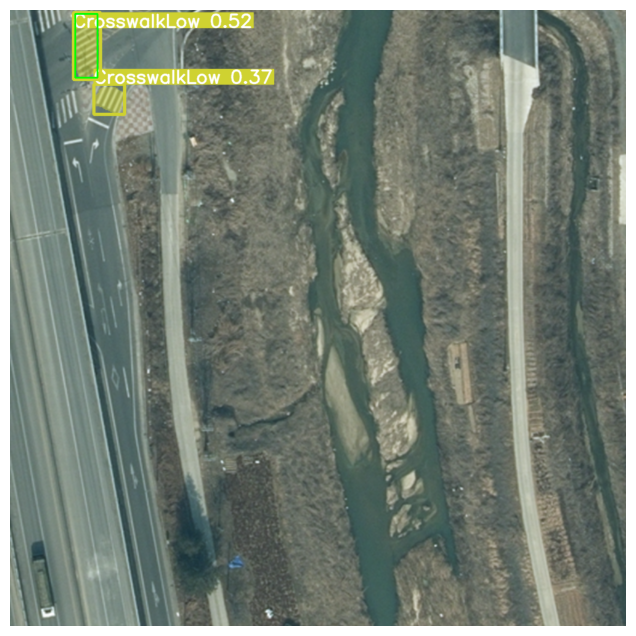

In [97]:
"""
from PIL import Image, ImageDraw

def visualize_bbox_on_image(image_path, bbox_coordinates):
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    scaled_bbox = [coord for coord in bbox_coordinates]  # 이미 1024x1024 크기에 스케일되어있으므로 스케일링 없이 사용

    draw.polygon(scaled_bbox, outline="red")

    image.show()



# 이미지 경로와 바운딩 박스 좌표값을 사용하여 시각화
image_path = "runs/segment/yolov8n_seg_infer_ftest/(B040)항공사진_202202205C00920021_15360_9216_(156,119-140,153-176,172-192,136).png"
bbox_coordinates = [108, 6, 145, 6, 145, 112, 108, 112]  # 바운딩 박스 좌표값

visualize_image_with_bboxes(image_path, bbox_coordinates)
"""

### 세그멘테이션 된 이미지 확인

In [59]:
"""
# define helper functions to show images - polygon shape
def imShow(path, lb_path):
  import cv2
  import matplotlib.pyplot as plt
  import numpy as np
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]

  file = open(lb_path, "r")
  strings = file.readlines()
  file.close()

  # Draw a rectangle with blue line borders of thickness of 2 px
  for line in strings:
    line = line.split()
    label = line[0]
    pts = []
    for index in range(1,len(line[1:])+1, 2):
      x_pt = int(width*float(line[index]))
      y_pt = int(height*float(line[index+1]))
      pts.append([x_pt,y_pt])

    pts = np.array(pts).reshape(1, -1, 2)

    image = cv2.polylines(image, pts, isClosed=True, color=(0, 255, 0), thickness=2)

  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()
  """

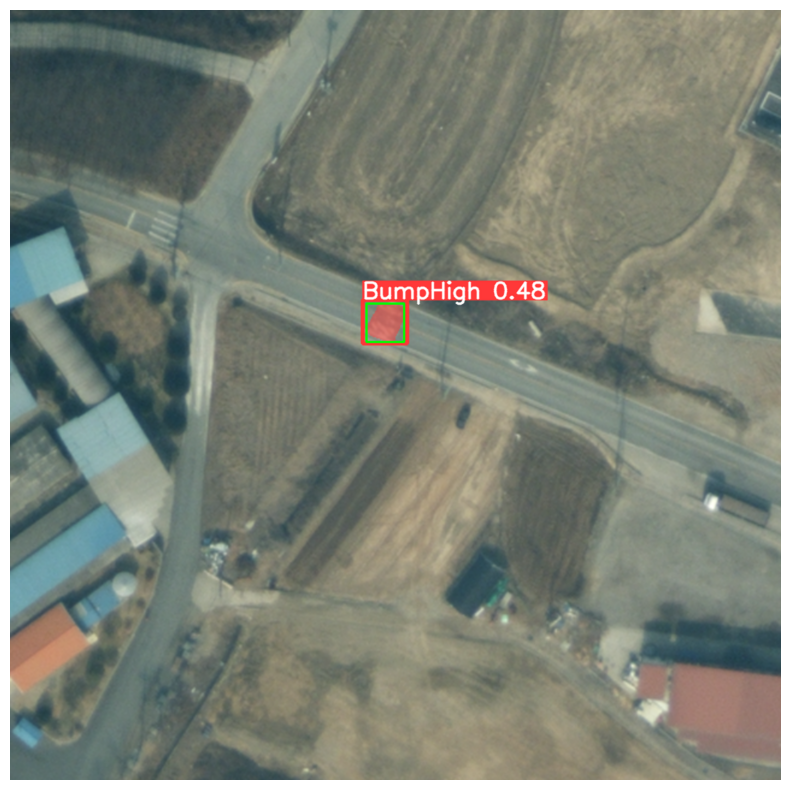

In [70]:
# imShow('runs/segment/yolov8n_seg_infer_valimages/(B040)항공사진_202202205C00940019_19456_7168_(495,385-477,428-509,440-527,398).png','runs/segment/yolov8n_seg_infer_valimages/labels/(B040)항공사진_202202205C00940019_19456_7168_(495,385-477,428-509,440-527,398).txt')